# Analysis Notebook – Comparison of CV3-Fv against experimental ensembles

**Author:** Fabian C. Spoendlin 

**Date:** November, 2025 

**Version:** v1.0

**Contact email:** matteo.cagiada@bio.ku.dk / fabian.spoendlin@stats.ox.ac.uk

---

## Overview

This Jupyter notebook accompanies the paper:

> **Uncovering the flexibility of CDR loops in antibodies and TCRs through large-scale molecular dynamics**  
> Matteo Cagiada, Fabian C. Spoendlin, King Ifashe, Charlotte M. Deane
> biorxiv - 2025

---

## How to Run

To run this notebook, clone the GitHub repository and run it. The files are already in the correct folders to execture the notebook.

### Requirements
- **Python version:** 3.9+  
- **Environment:** Conda
- **Dependencies:** numpy, pandas, matplotlib, seaborn, sklearn

### Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc

custom_palette = ['#86CB92', '#71B48D', '#404E7C', '#251F47', '#260F26']

In [26]:
def evaluate_prediction(y_pred_proba, y_test):    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    return auc(recall, precision), y_test.sum()/len(y_test) # pr_auc, random baseline

### Alternative conformation coverage

In [27]:
dfs_base = {}
dfs_sim = {}

for CDR in ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']:
    dfs_base[CDR] = pd.read_hdf(f'../src/experimental_ensembles/{CDR}_baseline.h5', f'{CDR}_baseline')
    dfs_sim[CDR] = pd.read_hdf(f'../src/experimental_ensembles/{CDR}_coverage.h5', f'{CDR}_coverage')

In [28]:
simulation_coverage = {}
simulation_coverage_tresholded = {}
baseline_coverage = {}
baseline_coverage_tresholded = {}
thresholds = np.linspace(0, 10, 101)
for CDR in dfs_sim.keys():
    simulation_coverage[CDR] = np.concatenate(dfs_sim[CDR].xray_coverage.values)
    baseline_coverage[CDR] = np.concatenate(dfs_base[CDR].xray_coverage_bl.values)

    simulation_coverage_tresholded[CDR] = []
    baseline_coverage_tresholded[CDR] = []
    for i in thresholds:
        simulation_coverage_tresholded[CDR].append((simulation_coverage[CDR] < i).sum() / simulation_coverage[CDR].shape[0])
        baseline_coverage_tresholded[CDR].append((baseline_coverage[CDR] < i).sum() / baseline_coverage[CDR].shape[0])

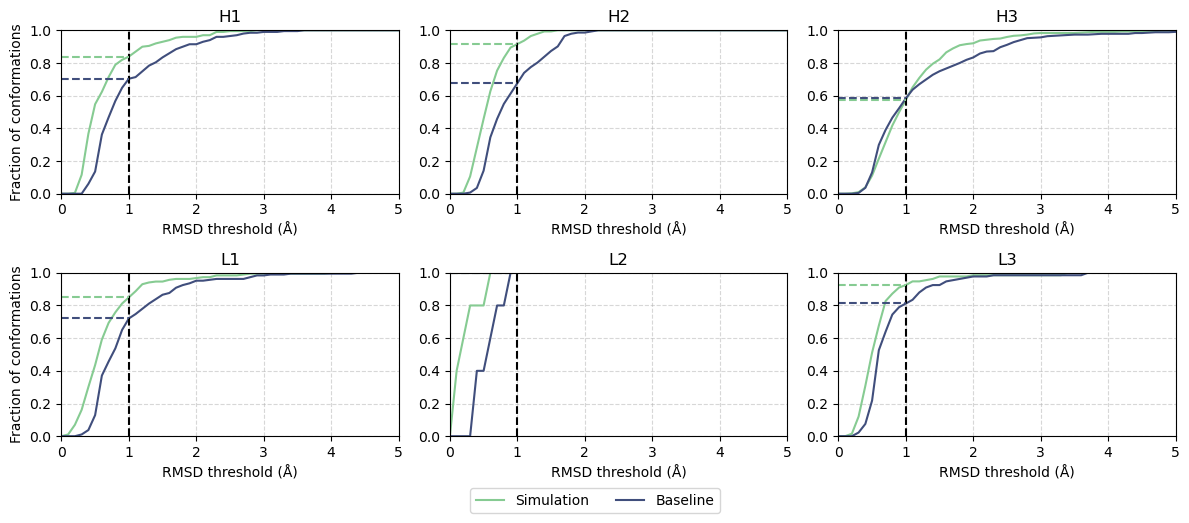

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
t = 1

axes = axes.flatten()

for i, CDR in enumerate(['H1', 'H2', 'H3', 'L1', 'L2', 'L3']):
    axes[i].plot(thresholds, simulation_coverage_tresholded[CDR], label='Simulation', color=custom_palette[0])
    axes[i].plot(thresholds, baseline_coverage_tresholded[CDR], label='Baseline', color=custom_palette[2])
    axes[i].set_title(CDR)

    # lines for tresholds
    idx = np.where(thresholds == t)[0][0]
    percentage_sim = simulation_coverage_tresholded[CDR][idx]
    percentage_base = baseline_coverage_tresholded[CDR][idx]
    axes[i].vlines(t, 0, 1, color='k', linestyle='--')
    axes[i].hlines(percentage_sim, 0, t, color=custom_palette[0], linestyle='--')
    axes[i].hlines(percentage_base, 0, t, color=custom_palette[2], linestyle='--')

axes[0].set_ylabel('Fraction of conformations')
axes[3].set_ylabel('Fraction of conformations')
for ax in axes.flatten():
    ax.set_xlabel('RMSD threshold (Å)')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1)
    ax.grid(axis='both', linestyle='--', alpha=0.5)
    # ax.legend(loc='lower right')

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.savefig(f'../figures/conformation_coverage.pdf', bbox_inches="tight")

### CDR flexibility

In [53]:
dfs = {}
for cdr in ['H1', 'H2', 'H3', 'L1', 'L3']:
    dfs[cdr] = pd.read_hdf(f'../src/experimental_ensembles/{cdr}_flexibility.h5', f'{cdr}_flexibility')
    
pr_aucs = {}
for i, (cdr, df) in enumerate(dfs.items()):
    pr_aucs[cdr] = get_pr_auc(df.rpair_l_95.values, df.flexible_binary.values)

pr_aucs = pd.DataFrame(pr_aucs, index=['Simulation', 'Random'])
pr_aucs.reset_index(inplace=True)
pr_aucs = pr_aucs.melt(id_vars='index')

fig, axes = plt.subplots(figsize=(5, 3.5))

sns.barplot(data=pr_aucs, x='variable', y='value', hue='index', palette=[custom_palette[0],custom_palette[-3]], ax=axes)

axes.set_ylim(0,1)
axes.grid(axis='y', linestyle='--', alpha=0.5)
axes.set_xlabel('')
fig.tight_layout()
fig.savefig(f'../figures/flexibility_classification_pr_auc.pdf')


NameError: name 'get_pr_auc' is not defined

### AbAngles

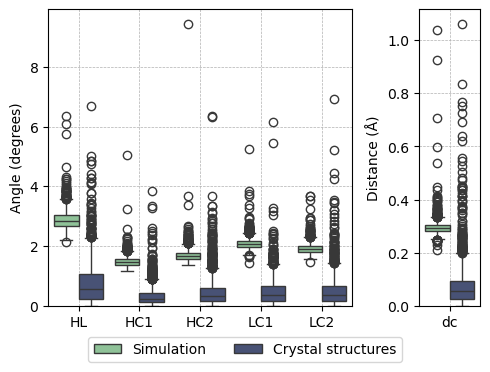

In [ ]:
df = pd.read_hdf(f'../src/experimental_ensembles/ab_angles_sim.h5', key='ab_angles')
abangles_crystal = np.load('../src/experimental_ensembles/ab_angles_exp.npy')
abangles_crystal_std = np.nanstd(abangles_crystal, axis=1)
abangles_crystal_std = pd.DataFrame(abangles_crystal_std, columns=['HL_std', 'HC1_std', 'HC2_std', 'LC1_std', 'LC2_std', 'dc_std'])
abangles_crystal_std['dataset'] = 'Crystal structures'

sele = df[df.HL_std < 10]
sele['dataset'] = 'Simulation'

combined = pd.concat([abangles_crystal_std, sele.loc[:, ['HL_std', 'HC1_std', 'HC2_std', 'LC1_std', 'LC2_std', 'dc_std', 'dataset']]], ignore_index=True)

data_long = combined.melt(
    id_vars='dataset', 
    value_vars=['HL_std', 'HC1_std', 'HC2_std', 'LC1_std', 'LC2_std', 'dc_std'], 
    var_name='measurement', 
    value_name='value'
)

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(5, 3.5))

sns.boxplot(x='measurement', y='value', hue='dataset', data=data_long[data_long['measurement'] != 'dc_std'], palette=[custom_palette[0], custom_palette[2]], hue_order=['Simulation', 'Crystal structures'],ax=axes[0])
sns.boxplot(x='measurement', y='value', hue='dataset', data=data_long[data_long['measurement'] == 'dc_std'], palette=[custom_palette[0], custom_palette[2]], hue_order=['Simulation', 'Crystal structures'],ax=axes[1])

axes[0].set_ylabel('Angle (degrees)')
axes[1].set_ylabel('Distance (Å)')
axes[0].set_xticklabels(['HL', 'HC1', 'HC2', 'LC1', 'LC2'])
axes[1].set_xticklabels(['dc'])

for ax in axes:
    ax.set_xlabel('')
    ax.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    ax.set_ylim(bottom=0)

if axes[0].get_legend() is not None:
    axes[0].legend_.remove()
if axes[1].get_legend() is not None:
    axes[1].legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.savefig('../figures/ab_angles.pdf',bbox_inches="tight")